## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

#### 1. Read in the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('chronic_kidney_disease_full.csv')
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


#### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:
1) hypertension and CKD
2) diabetes and CKD
3) sodium and CKD

---

## Step 3: Explore the data.

#### 3. How much of the data is missing from each column?

In [3]:
data.isna().sum().sort_values(ascending=False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

#### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

Answer: 158 Dataframes would remain and the downside of this would  be
1) Data will be missing from our data set which will give is undesirable results
2) Because close to half our data set got dropped, our data may be too inconsistent and since this is medical data, we may miss a few unique critera vital for our data.

In [4]:
data_2 = data.dropna(axis=0)

In [5]:
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [6]:
data_2.isna().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

#### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:
1) Common testing for those at an elderly age but not younger
2) Our data could have outliers (examples of rare cases)
3) Bloodwork/testing could've been inconclusively 


---

## Step 4: Model the data.

#### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

Answer: So if you have CKD tell them that they have CKD and on the off chance they they don't have CKD, tell them they have it anyways.

#### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

In other words, we minimized false negatives for Sensitivity.

#### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: People without CKD will think that they have CKD

#### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: Tell no one they have CKD

#### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

We minimized false positives, optimizing Specificity.

#### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: Those who have CKD will think that they don't

#### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

Remember to do a train/test split. We suggest using GridSearchCV and pipelines.

In [7]:
data_2['htn'] = data_2['htn'].replace('no', 0)

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\2629215583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['htn'] = data_2['htn'].replace('no', 0)


In [8]:
data_2['htn'] = data_2['htn'].replace('yes', 1)

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\2857441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['htn'] = data_2['htn'].replace('yes', 1)


In [9]:
data_2.htn.value_counts()

0    124
1     34
Name: htn, dtype: int64

In [10]:
data_2.dm

3       no
9      yes
11     yes
14     yes
20     yes
      ... 
395     no
396     no
397     no
398     no
399     no
Name: dm, Length: 158, dtype: object

In [11]:
data_2['dm'] = data_2['dm'].replace('no', 0)

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\2121682475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['dm'] = data_2['dm'].replace('no', 0)


In [12]:
data_2['dm'] = data_2['dm'].replace('yes', 1)

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\925526221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['dm'] = data_2['dm'].replace('yes', 1)


In [13]:
data_2.htn.value_counts()

0    124
1     34
Name: htn, dtype: int64

In [14]:
data_2.sod.value_counts()

135.0    22
147.0    12
150.0    12
140.0    11
139.0    10
142.0    10
136.0     9
141.0     9
144.0     8
138.0     8
137.0     8
145.0     6
146.0     6
143.0     4
132.0     3
130.0     3
131.0     3
114.0     2
122.0     2
120.0     2
125.0     2
133.0     2
111.0     1
124.0     1
115.0     1
134.0     1
Name: sod, dtype: int64

In [15]:
data_2['class'] = data_2['class'].replace('ckd',1)
data_2['class'] = data_2['class'].replace('notckd',0)

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\3815499013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['class'] = data_2['class'].replace('ckd',1)
C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\3815499013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['class'] = data_2['class'].replace('notckd',0)


In [16]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 3 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     158 non-null    float64
 1   bp      158 non-null    float64
 2   sg      158 non-null    float64
 3   al      158 non-null    float64
 4   su      158 non-null    float64
 5   rbc     158 non-null    object 
 6   pc      158 non-null    object 
 7   pcc     158 non-null    object 
 8   ba      158 non-null    object 
 9   bgr     158 non-null    float64
 10  bu      158 non-null    float64
 11  sc      158 non-null    float64
 12  sod     158 non-null    float64
 13  pot     158 non-null    float64
 14  hemo    158 non-null    float64
 15  pcv     158 non-null    float64
 16  wbcc    158 non-null    float64
 17  rbcc    158 non-null    float64
 18  htn     158 non-null    int64  
 19  dm      158 non-null    int64  
 20  cad     158 non-null    object 
 21  appet   158 non-null    object 
 22  pe

# EDA

def EDA(df,y):
    columns = df.columns
    index = len(columns)
    iterated_columns = range(0,index+1)
    count = 0
    
    plt.figure(figsize=(8, 12))
    heatmap = sns.heatmap(df.corr()[[y]].sort_values(by=y, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title(f"Features Correlating with {y}", fontdict={'fontsize':18}, pad=16);
    # plt.savefig(f"Images/{y}_correlation.png")
    
    while count < index+1:
        name = df.columns[count]
        
        displot  = sns.displot(df[name]);
        plt.title(f"{name}values")
        # plt.savefig(f"Images/Distribution/{name}.png")
        
        histogram  = sns.histplot(df[name]);
        plt.title(f"{name}values")
        # plt.savefig(f"Images/Histogram/{name}.png")
        count +=1
        
    

EDA(data_2,'class')

In [17]:
data_2.ane.value_counts()

no     142
yes     16
Name: ane, dtype: int64

In [18]:
data_2['rbc'] = data_2['rbc'].replace({'abnormal':0,'normal':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\1596870801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['rbc'] = data_2['rbc'].replace({'abnormal':0,'normal':1})


In [19]:
data_2['pc'] = data_2['pc'].replace({'abnormal':0,'normal':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\1693885757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['pc'] = data_2['pc'].replace({'abnormal':0,'normal':1})


In [20]:
data_2['pcc'] = data_2['pcc'].replace({'notpresent':0,'present':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\2621662260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['pcc'] = data_2['pcc'].replace({'notpresent':0,'present':1})


In [21]:
data_2['ba'] = data_2['ba'].replace({'notpresent':0,'present':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\940781543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['ba'] = data_2['ba'].replace({'notpresent':0,'present':1})


In [22]:
data_2['cad'] = data_2['cad'].replace({'no':0,'yes':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\89604879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['cad'] = data_2['cad'].replace({'no':0,'yes':1})


In [23]:
data_2['pe'] = data_2['pe'].replace({'no':0,'yes':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\2393055897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['pe'] = data_2['pe'].replace({'no':0,'yes':1})


In [24]:
data_2['ane'] = data_2['ane'].replace({'no':0,'yes':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\3814738331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['ane'] = data_2['ane'].replace({'no':0,'yes':1})


In [25]:
data_2['appet'] = data_2['appet'].replace({'poor':0,'good':1})

C:\Users\Sparrow\AppData\Local\Temp\ipykernel_7432\2132058632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['appet'] = data_2['appet'].replace({'poor':0,'good':1})


In [26]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 3 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     158 non-null    float64
 1   bp      158 non-null    float64
 2   sg      158 non-null    float64
 3   al      158 non-null    float64
 4   su      158 non-null    float64
 5   rbc     158 non-null    int64  
 6   pc      158 non-null    int64  
 7   pcc     158 non-null    int64  
 8   ba      158 non-null    int64  
 9   bgr     158 non-null    float64
 10  bu      158 non-null    float64
 11  sc      158 non-null    float64
 12  sod     158 non-null    float64
 13  pot     158 non-null    float64
 14  hemo    158 non-null    float64
 15  pcv     158 non-null    float64
 16  wbcc    158 non-null    float64
 17  rbcc    158 non-null    float64
 18  htn     158 non-null    int64  
 19  dm      158 non-null    int64  
 20  cad     158 non-null    int64  
 21  appet   158 non-null    int64  
 22  pe

In [27]:
data_2['class'].value_counts()

0    115
1     43
Name: class, dtype: int64

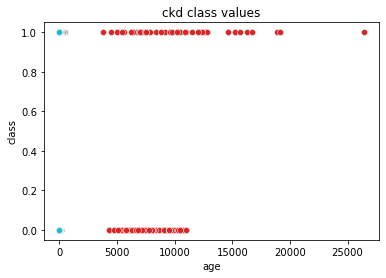

In [57]:
for column in data_2.columns:
    no_ckd = data[data['class'] == 0]
    sns.scatterplot(data = data_2 , x = column , y='class')
    plt.title(f"no_ckd {column} values") 
    plt.savefig(f"no_ckd_{column}_scatterplot.png")
    
    ckd = data[data['class'] == 1]
    sns.scatterplot(data =data_2 , x = column , y='class')
    plt.title(f"ckd {column} values") 
    plt.savefig(f"ckd_{column}_scatterplot.png")
    


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [29]:
X = data_2.drop(columns='class')
y = data_2['class']

In [30]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=22)

In [31]:
sc = StandardScaler()
logreg = LogisticRegression()

In [32]:
z_train = sc.fit_transform(X_train)
z_test = sc.transform(X_test)

In [33]:
logreg.fit(z_train, y_train)
logreg.coef_

array([[ 0.224299  ,  0.19529628, -0.47851469,  1.05572701,  0.16468552,
        -0.65875554, -0.48843767,  0.27199969,  0.02614775,  0.27088852,
         0.29628167,  0.31371791, -0.41589046,  0.02034453, -0.46419794,
        -0.43603912,  0.56020448, -0.20742491,  0.63475199,  0.41279569,
         0.02035219, -0.05707567,  0.08049096,  0.10090521]])

In [34]:
logreg.intercept_

array([-2.16599309])

In [35]:
y_pred = logreg.predict(z_test)

In [36]:
pred = logreg.predict(z_train)

In [37]:
mse = mean_squared_error(y_test, y_pred)

In [38]:
rse = mse**.5
print(rse)

0.0


In [39]:
logreg.score(z_train, y_train)

1.0

In [40]:
logreg.score(z_test,y_test)

1.0

In [41]:
logreg.coef_

array([[ 0.224299  ,  0.19529628, -0.47851469,  1.05572701,  0.16468552,
        -0.65875554, -0.48843767,  0.27199969,  0.02614775,  0.27088852,
         0.29628167,  0.31371791, -0.41589046,  0.02034453, -0.46419794,
        -0.43603912,  0.56020448, -0.20742491,  0.63475199,  0.41279569,
         0.02035219, -0.05707567,  0.08049096,  0.10090521]])

In [42]:
lasso = Lasso()
params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0,100.0]}
lasso_grid = GridSearchCV(lasso, param_grid=params)

In [43]:
lasso_grid

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

In [44]:
lasso_grid.fit(z_train, y_train)
lasso_grid.best_estimator_


Lasso(alpha=0.01)

In [45]:
lasso_grid.score(z_train, y_train)

0.9576884453378535

In [46]:
pd.DataFrame(lasso_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001388,0.000492,0.000608,0.000496,0.001,{'alpha': 0.001},0.877926,0.884893,0.910673,0.888762,0.885248,0.889500,0.011154,2
1,0.000804,0.000402,0.000192,0.000385,0.01,{'alpha': 0.01},0.957039,0.978601,0.915028,0.872112,0.904219,0.925400,0.038019,1
2,0.000601,0.000491,0.000396,0.000486,0.1,{'alpha': 0.1},0.921723,0.921802,0.851673,0.688175,0.730313,0.822737,0.097055,3
3,0.000411,0.000822,0.000592,0.000483,1.0,{'alpha': 1.0},-0.000433,-0.002528,-0.002528,-0.120251,-0.024139,-0.029976,0.045963,4
4,0.000990,0.000014,0.000000,0.000000,10.0,{'alpha': 10.0},-0.000433,-0.002528,-0.002528,-0.120251,-0.024139,-0.029976,0.045963,4
5,0.001000,0.000025,0.000396,0.000485,100.0,{'alpha': 100.0},-0.000433,-0.002528,-0.002528,-0.120251,-0.024139,-0.029976,0.045963,4


In [47]:
y_test_preds = lasso_grid.predict(z_test)
lasso_mse = mean_squared_error(y_test, y_test_preds)
lasso_rsme = lasso_mse**.5
print(lasso_rsme)

0.12779574965430135


---

## Step 5: Evaluate the model.

#### 13. How well does your model perform in terms of accuracy?

`

Answer: It performed well with 97% Accuracy

#### 14. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
confusion_matrix(y_train,pred)

array([[93,  0],
       [ 0, 33]], dtype=int64)

#### 15. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: Focusing on a lower misclassification rate so patients wh do have CKD can be informed and seek treatement immediately.

#### 16. How does your model perform for your chosen metric?

Answer: While all else is constant,as htn increases by 1, the person is is 4.5 more likely to have CKD than compared to other variables

In [50]:
coefficents = np.exp(logreg.coef_) #np.exp used to have logistic coefficents make more sense
print(list(coefficents))

[array([1.25144515, 1.21567111, 0.61970316, 2.87406388, 1.17902229,
       0.51749494, 0.61358427, 1.31258659, 1.02649261, 1.31112889,
       1.34484891, 1.36850364, 0.65975254, 1.02055289, 0.62863911,
       0.64659243, 1.75103052, 0.81267427, 1.8865542 , 1.51103627,
       1.02056071, 0.94452259, 1.08381905, 1.10617178])]


In [51]:
le_features = data_2.columns
le_features

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

#### 17. Plot the ROC Curve. 
Receiver operating characterisitc

C:\Users\Sparrow\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


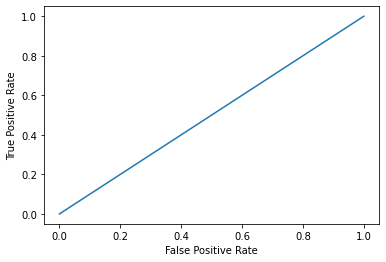

In [52]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#### 18. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

###
1) It's a great way to organize categorical data
2) Logistic Regression when compared to Linear Regression, is easier to implement and more efficent to train

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

We'll leave that for another day!